In [1]:
# Notebook initialization with import of all required modules
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from collections import OrderedDict


# PyDrive initialization
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
!pip install httplib2==0.15.0
!pip install google-api-python-client==1.6

import numpy as np 
import pandas as pd
# Garbage Collector interface (nettoyage des variables et autres pas utilisées
# pour libérer de la mémoire)
import gc 
import time
# Utilities for with-statement contexts
from contextlib import contextmanager 
# Gradient boosting framework that uses tree based learning algorithms
from lightgbm import LGBMClassifier 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy.stats as st
import re
import time
from datetime import datetime,timedelta
import dateutil
import random as rd
import pickle

from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold,cross_val_score
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, roc_curve,precision_recall_fscore_support,accuracy_score,auc,make_scorer,precision_recall_curve,confusion_matrix,f1_score
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
import lightgbm as lgbm
from hyperopt import fmin, tpe, Trials,hp,space_eval
import pickle
from tabulate import tabulate

import warnings

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Ce notebook correspond au projet 7 du parcours Data Scientist. Ce projet consiste en l'implémentation d'un modèle de scoring, qui sera ensuite disponible via un dasboard interactif. Nous développerons donc ici la modélisation de ce scoring. 

<h2>Sommaire</h2>

1) Initialisation des variables de modélisation

2) Benchmark des modèles de machine learning

In [2]:
link1 = "https://drive.google.com/open?id=1IJmP7PGn8JHOZx_0_vpGh3mHMfX6ESDw"
fluff, id = link1.split('=')
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('data_model.csv')
data = pd.read_csv('data_model.csv', sep='\t')
print ("Dataset importé")


Dataset importé


# 1) Initialisation des variables de modélisation

Pour commencer, nous étudions déjà la répartition des scores de clients connus. En effet, ce score est binaire : il est soit de 0 pour les bons clients, soit de 1 pour les mauvais clients. Nous pouvons ainsi voir qu'il y a environ 8% de mauvais clients uniquement, cela sera donc à prendre en compte lors de notre modélisation.

{0.0: 282682, 1.0: 24825}


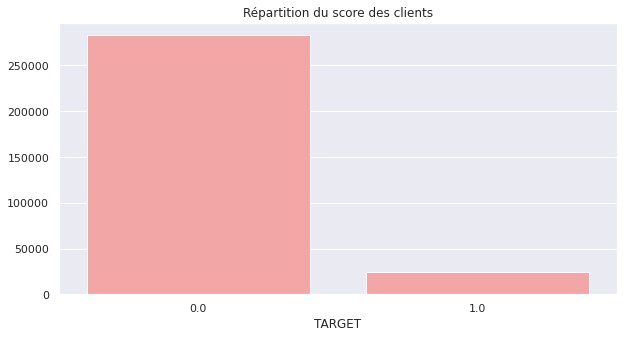

In [3]:
target = data.groupby(["TARGET"])
counttarget = target["SK_ID_CURR"].count()
counttarget = counttarget.sort_values(ascending=False)
targetlabels = counttarget.index
targetsizes = counttarget.values

target_dict = {}
for n in range(len(targetlabels)):
    target_dict[targetlabels[n]] = targetsizes[n]
print (target_dict)

sns.set()
fig1, ax1 = plt.subplots(figsize=(10, 5))
sns.barplot(x=targetlabels, y=targetsizes, color='#ff9999', ax=ax1)
plt.title("Répartition du score des clients")
plt.show()


Nous devons ensuite établir nos différentes valeur de train et de test. 

Pour commencer, nous nettoyons tout d'abord nos données, en remplaçant les valeurs infinies par des NaN, qui sont ensuite calculées par l'utilisation de l'algorithme IterativeImputer. Cet algorithme impute ainsi aux valeurs manquantes la médiane des autres valeurs disponibles.

Une fois ce nettoyage effectué, nous calculons les échantillons train et test en stratifiant selon y (donc selon nos deux valeurs de score vues précédemment). Enfin, nous définissons également les Folds utilisés dans nos futurs modèles testés, et nous scalons et transformons nos X.

In [4]:
def nan_values(x):
    if x.isnull().any():
        print (x, " : Problem")


# Choix de notre échantillon

data = data.sample(frac=0.01, random_state=0)

data = data.astype('float64')
data = data.replace([np.inf, -np.inf], np.nan)

valmax = np.finfo(np.float64).max

print ("Imputation")

X = data
y = X["TARGET"]
imp = IterativeImputer(missing_values=np.nan, sample_posterior=False,
                       max_iter=10, tol=0.001, n_nearest_features=4,
                       initial_strategy='median', random_state=0)
imp.fit(X)
X_imp = pd.DataFrame(data=imp.transform(X), columns=X.columns)
y = y.fillna(0)

X_imp.apply(lambda x: nan_values(x))

print ("Taille du dataframe X : ", len(X_imp))
print ("Taille du dataframe X : ", len(y))
print ("Nombre de features :", len(X_imp.columns))

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_imp, y, train_size=0.8,
                                                stratify=y, random_state=0)
Xtest_all = Xtest
Xtest = Xtest.drop(['TARGET', 'SK_ID_CURR', 'index'], axis=1)
Xtrain = Xtrain.drop(['TARGET', 'SK_ID_CURR', 'index'], axis=1)
print ("Len data : {}".format(len(data)))
print ("Len Xtrain : {} / Len Ytrain : {}".format(len(Xtrain), len(Ytrain)))
print ("Len Xtest : {} / Len Ytest : {}".format(len(Xtest), len(Ytest)))


# Création du modèle de Fold (ici pas de stratification donc logiquement KFold)
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
print (folds)


std_scale = StandardScaler().fit(Xtrain)
Xtrain_scaled = std_scale.transform(Xtrain)
Xtest_scaled = std_scale.transform(Xtest)


Imputation


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Taille du dataframe X :  3563
Taille du dataframe X :  3563
Nombre de features : 798
Len data : 3563
Len Xtrain : 2850 / Len Ytrain : 2850
Len Xtest : 713 / Len Ytest : 713
StratifiedKFold(n_splits=10, random_state=0, shuffle=True)


# Benchmark des modèles de machine learning disponibles

Tout d'abord, nous savons que nous allons utiliser différents modèles, mais en utlisant toujours la même technique : l'algorithme GridSearchCV, couplé ensuite au calcul de plusieurs scores différents. 

L'algorithme GridSearchCV nous permet en effet de faire tourner, avec les mêmes paramètres de base, tout type d'algorithme de la même manière, ce qui facilite la comparaison entre eux (même fold,...). Les paramètres spécifiques au modèle sont indiqués à part et ajoutés à cet algorithme.

Pour les scores calculés, il y en a donc plusieurs :
- l'accuracy est le ration des prédictions correctes par rapport au nombre total d'observations. Il ne sera cependant ici qu'indicateur et peu utile, vu que nos données ne sont pas symmétriques.
- la précision est le ratio des observations prédites correctement sur le nombre d'observations prédites (donc plus il est haut, mieux c'est) 
- le recall est le ration des observations prédites correctement sur le nombre d'observations de la même classe (donc plus il est haut et supérieur à 0.5, mieux c'est)
- le F1-score est la moyenne pondérée entre la précision et le recall. C'est la mesure utilisée lorsque les données sont assymétriques comme les nôtres, à la place de l'accuracy (formule : 2*(Recall * Precision) / (Recall + Precision))

Le score que nous utiliserons le plus sera calculé par la suite : ce sera le ROC_AUC, à savoir l'aire sous la courbe


In [ ]:
def overall_average_score(actual, prediction):
    precision, recall, f1_score, _ = precision_recall_fscore_support(
        actual, prediction, average='binary')
    acc = accuracy_score(actual, prediction)
    total_score = [precision, recall, f1_score, acc]
    return total_score


Le premier modèle testé va être le DummyClassifier. Ce modèle est le modèle naïf, selon des règles simples :
- 'most_frequent' prédit toujours la valeur la plus fréquente de l'échantillon train (ici 0)
- 'stratified' prédit la valeur selon la répartition dans l'échantillon train (donc92% de 0 et 8% de 1)
- 'uniform' prédit la valeur uniformément au hasard.

Ce modèle nous servira donc uniquement de base de comparaison, car ce modèle sera toujours à un ROC_AUC de 0.5.



In [ ]:
start_time = time.time()

parameters = {'strategy': ['most_frequent', 'stratified', 'uniform']}

dum = DummyClassifier(random_state=0)
dumc = GridSearchCV(cv=folds, estimator=dum, param_grid=parameters,
                    return_train_score=True)
dumc.fit(Xtrain_scaled, Ytrain)
dumcpred = dumc.predict(Xtest_scaled)

dumctime = time.time()-start_time

print ("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:",
       dumc.best_params_)

dumcstats = ["Dummy regressor", dumctime]
dumcscores = overall_average_score(Ytest, dumcpred)

for n in dumcscores:
    dumcstats.append(n)

print(dumc.predict_proba(Xtest))


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: {'strategy': 'most_frequent'}
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Le modèle suivant est le kNN classifier qui va calculer les valeurs recherchées en utilisant les k données voisines les plus proches. 

Il n'existe qu'un unique hyper-paramètre sur lequel nous pouvons jouer pour optimiser notre modèle : le nombre de voisins à sélectionner pour chacune des valeurs à calculer. Nous choisissons une unique valeur ici, comme il s'agit juste d'un test des modèles.

In [ ]:
start_time = time.time()

parameters = {'n_neighbors': [5, 10]}

knn = KNeighborsClassifier()
knnc = GridSearchCV(cv=folds, estimator=knn, param_grid=parameters,
                    return_train_score=True)
knnc.fit(Xtrain_scaled, Ytrain)
knncpred = knnc.predict(Xtest_scaled)

knnctime = time.time()-start_time

knncstats = ["kNN Classifier", knnctime]
knncscores = overall_average_score(Ytest, knncpred)

for n in knncscores:
    knncstats.append(n)

print (knnc.predict_proba(Xtest))


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[0.9 0.1]
 [0.9 0.1]
 [0.9 0.1]
 ...
 [0.9 0.1]
 [0.8 0.2]
 [0.9 0.1]]


Le modèle suivant est le Logistic Regression, qui est une régression binaire. La seule variable changée ici sera le solveur, à savoir l'algorithme utilisée pour optimiser le résultat. 

In [ ]:
start_time = time.time()

parameters = {'solver': ['lbfgs', 'liblinear']}

lr = LogisticRegression(random_state=0)
lrc = GridSearchCV(cv=folds, estimator=lr, param_grid=parameters,
                   return_train_score=True)
lrc.fit(Xtrain_scaled, Ytrain)
lrcpred = lrc.predict(Xtest_scaled)

lrctime = time.time()-start_time

lrcstats = ["Logistic Regression", lrctime]
lrcscores = overall_average_score(Ytest, lrcpred)

for n in lrcscores:
    lrcstats.append(n)

print(lrc.predict_proba(Xtest))


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [0. 1.]]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Le modèle suivant est le SVC ou C-Support Vector Classification, correspondant donc à une méthode d'apprentissage supervisé. Les paramètres modifiables sont 
- "C" ou le paramètre d'erreur
- "gamma" ou le coefficient du kernel. Plus il est haut et plus chaque valeur d'entraînement est forte.
- "probabilty" mise à True sert ici à la création de notre future courbe ROC.

Ici, on fixe les valeurs comme il s'agit d'un test.

In [ ]:
start_time = time.time()

parameters = {'kernel': ['rbf', 'linear'], 'gamma': ['scale', 0.001],
              'C': [1.0, 100.], 'probability': [True]}

svclas = svm.SVC(random_state=0)
svmc = GridSearchCV(cv=folds, estimator=svclas, param_grid=parameters,
                    return_train_score=True)
svmc.fit(Xtrain_scaled, Ytrain)
svmcpred = svmc.predict(Xtest_scaled)

svmctime = time.time()-start_time

svmcstats = ["SVM", svmctime]
svmcscores = overall_average_score(Ytest, svmcpred)

for n in svmcscores:
    svmcstats.append(n)

print(svmc.predict_proba(Xtest))


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[0.8995789 0.1004211]
 [0.8995789 0.1004211]
 [0.8995789 0.1004211]
 ...
 [0.8995789 0.1004211]
 [0.8995789 0.1004211]
 [0.8995789 0.1004211]]


Nous testons ensuite le MLP Classifier qui utilise un réseau de neurones à propagation avant. Il prend donc les échantillons d'entrée et utilise des couches de neurones pour effectuer les calculs.

Pour le MLP, il existe 4 hyper-paramètres sur lesquels nous pouvons jouer pour optimiser notre modèle :

- 'hidden_layer_sizes' ou le nombre de couches et le nombre de neurones de chaque couche.
-'activation' ou les différents types de fonctions des couches renvoyant différentes fonctions
- 'solver' pour l'optimisation des poids


In [ ]:
start_time = time.time()

parameters = {'hidden_layer_sizes': [(796,), (796, 796)]}

mlp = MLPClassifier(random_state=0)
mlpc = GridSearchCV(cv=folds, estimator=mlp, param_grid=parameters,
                    return_train_score=True)
mlpc.fit(Xtrain_scaled, Ytrain)
mlpcpred = mlpc.predict(Xtest_scaled)

mlpctime = time.time()-start_time

mlpcstats = ["MLP", mlpctime]
mlpcscores = overall_average_score(Ytest, mlpcpred)

for n in mlpcscores:
    mlpcstats.append(n)

print(mlpc.predict_proba(Xtest))


[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


Nous testons ensuite la ridge classifier qui permet de restreindre l'amplitude des poids avec un effet de sélection groupée : les variables corrélées auront le même coefficient. Ainsi, les variables corrélées vont se combiner et se renforcer mutuellement.


In [ ]:
start_time = time.time()

parameters = {}

rid = RidgeClassifier(random_state=0)
ridc = GridSearchCV(cv=folds, estimator=rid, param_grid=parameters,
                    return_train_score=True)
ridc.fit(Xtrain_scaled, Ytrain)
ridcpred = ridc.predict(Xtest_scaled)

ridctime = time.time()-start_time

ridcstats = ["Ridge Classifier", ridctime]
ridcscores = overall_average_score(Ytest, ridcpred)

for n in ridcscores:
    ridcstats.append(n)

print(ridc.decision_function(Xtest))


[ 3.55146949e+08  4.78641131e+07  5.12556588e+07 -2.32610052e+08
  5.13635772e+07  1.85330148e+08  1.36468088e+08  1.92590481e+08
  1.41858897e+08  1.68611325e+08  1.67107104e+08  6.54299192e+07
  2.84948316e+08  3.64740809e+08  6.63341194e+08 -2.84597486e+07
  6.50765316e+07  7.68181421e+07  2.11353113e+08  2.43856089e+08
  1.41520021e+08 -3.15142742e+08  4.18768618e+07  1.00645143e+08
  3.39664981e+08  3.29693674e+07  2.67097362e+08  3.28591120e+08
  8.68020593e+07  4.26507676e+07  2.64961519e+06 -2.21589991e+08
 -1.39483212e+07 -6.91358760e+08  2.35230787e+08  3.85079435e+08
  1.22493869e+08  1.43434505e+08  1.88511392e+08  1.39297792e+08
  8.17675969e+07  1.32352422e+08  6.23732905e+07  1.18693104e+08
  1.19836745e+09  1.03459294e+09  5.05421297e+07  1.89642523e+08
  8.66157274e+07  9.89090852e+07  2.28729412e+08  1.96915143e+08
  1.95750138e+08  1.12297050e+08  3.26291995e+07 -2.57627902e+08
  4.10297405e+08  5.30011872e+07  2.19886519e+08  1.00262206e+08
  3.98595218e+08  3.83346

Nous testons enfin le RFClassifier qui combine de multiples arbres de décision pour fusionner leurs prédictions afin d'obtenir une prédiction finale plus stable et précis.

Pour le RF, il existe 3 hyper-paramètres sur lesquels nous pouvons jouer pour optimiser notre modèle. Nous jouons cependant ici que sur un seul, à savoir le nombre d'estimateurs, qui est le nombre d'arbres de décision utilisés.

In [ ]:
start_time = time.time()

parameters = {'max_depth': [None, 100]}


rf = RandomForestClassifier(random_state=0)
rfc = GridSearchCV(cv=folds, estimator=rf, param_grid=parameters,
                   return_train_score=True)
rfc.fit(Xtrain_scaled, Ytrain)
rfcpred = rfc.predict(Xtest_scaled)

rfctime = time.time()-start_time

rfcstats = ["Random Forest", rfctime]
rfcscores = overall_average_score(Ytest, rfcpred)

for n in rfcscores:
    rfcstats.append(n)

print(rfc.predict_proba(Xtest))


[[0.43 0.57]
 [0.44 0.56]
 [0.44 0.56]
 ...
 [0.44 0.56]
 [0.41 0.59]
 [0.44 0.56]]


Le modèle suivant est le LightGBMClassifier, qui est un modèle basé sur le Gradient Boosting et utilisant des algorithmes basés sur les arbres de décision. 

In [ ]:
start_time = time.time()

parameters = {}

lightgbm = lgbm.LGBMClassifier(random_state=0)

lgbmc = GridSearchCV(cv=folds, estimator=lightgbm, param_grid=parameters,
                     return_train_score=True)
lgbmc.fit(Xtrain_scaled, Ytrain)
lgbmcpred = lgbmc.predict(Xtest_scaled)

lgbmctime = time.time()-start_time

lgbmcstats = ["LightGBM Classifier", lgbmctime]
lgbmcscores = overall_average_score(Ytest, lgbmcpred)

for n in lgbmcscores:
    lgbmcstats.append(n)

print(lgbmc.predict_proba(Xtest))


[[9.99414120e-01 5.85879664e-04]
 [9.99702765e-01 2.97235108e-04]
 [9.98378718e-01 1.62128178e-03]
 ...
 [9.97368725e-01 2.63127522e-03]
 [9.99387295e-01 6.12704854e-04]
 [9.99532616e-01 4.67384457e-04]]


Enfin, le dernier modèle est le GaussianProcessClassifier. Un processus gaussien est un ensemble de variables aléatoires où chaque ensemble de variables suit une distribution normale multivariée (chaque combinaison linéaire finie est normalement distribuée). Sachant que nos résultats ne sont pas répartis de manière normale, il serait cependant étonnant que ce modèle soit efficace.

In [ ]:
start_time = time.time()

parameters = {}

gp = GaussianProcessClassifier(random_state=0)

gpc = GridSearchCV(cv=folds, estimator=gp, param_grid=parameters,
                   return_train_score=True)
gpc.fit(Xtrain_scaled, Ytrain)
gpcpred = gpc.predict(Xtest_scaled)

gpctime = time.time()-start_time

gpcstats = ["Gaussian Process", gpctime]
gpcscores = overall_average_score(Ytest, gpcpred)

for n in gpcscores:
    gpcstats.append(n)

print(gpc.predict_proba(Xtest))


[[0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 ...
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]]


Maintenant que nous avons calculé tous les modèles que nous voulions tester, nous pouvons tracer leurs courbes ROC, et calculer leur score AUC. Visuellement et selon le score AUC, nous pouvons donc dire que c'est le modèle Random Forest qui semble donner les meilleurs résultats, c'est donc celui que nous allons optimiser. Il a en effet un AUC score de 0.64, mais une accuracy de 0.92, ce qui est donc largement améliorable (0.92 étant le minimum à obtenir vu notre répartition des scores)


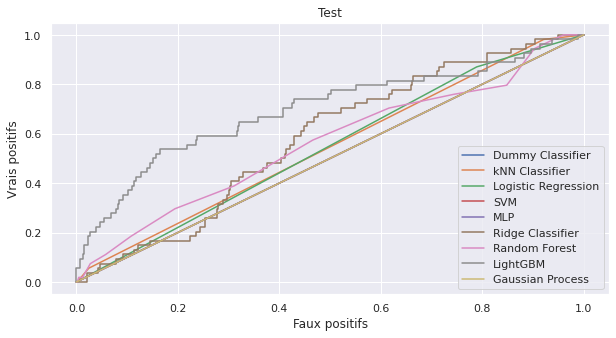

In [ ]:
sns.set()
fig1, ax1 = plt.subplots(figsize=(10, 5))
faux_positifs_dum, vrais_positifs_dum, seuil_dum = roc_curve(
    Ytest, dumc.predict_proba(Xtest)[:, 1])
plt.plot(faux_positifs_dum, vrais_positifs_dum, label="Dummy Classifier")
dumcstats.append(auc(faux_positifs_dum, vrais_positifs_dum))
faux_positifs_knn, vrais_positifs_knn, seuil_knn = roc_curve(
    Ytest, knnc.predict_proba(Xtest)[:, 1])
plt.plot(faux_positifs_knn, vrais_positifs_knn, label="kNN Classifier")
knncstats.append(auc(faux_positifs_knn, vrais_positifs_knn))
faux_positifs_lr, vrais_positifs_lr, seuil_lr = roc_curve(
    Ytest, lrc.predict_proba(Xtest)[:, 1])
plt.plot(faux_positifs_lr, vrais_positifs_lr, label="Logistic Regression")
lrcstats.append(auc(faux_positifs_lr, vrais_positifs_lr))
faux_positifs_svm, vrais_positifs_svm, seuil_svm = roc_curve(
    Ytest, svmc.predict_proba(Xtest)[:, 1])
plt.plot(faux_positifs_svm, vrais_positifs_svm, label="SVM")
svmcstats.append(auc(faux_positifs_svm, vrais_positifs_svm))
faux_positifs_mlp, vrais_positifs_mlp, seuil_mlp = roc_curve(
    Ytest, mlpc.predict_proba(Xtest)[:, 1])
plt.plot(faux_positifs_mlp, vrais_positifs_mlp, label="MLP")
mlpcstats.append(auc(faux_positifs_mlp, vrais_positifs_mlp))
faux_positifs_rid, vrais_positifs_rid, seuil_rid = roc_curve(
    Ytest, ridc.decision_function(Xtest))
plt.plot(faux_positifs_rid, vrais_positifs_rid, label="Ridge Classifier")
ridcstats.append(auc(faux_positifs_rid, vrais_positifs_rid))
faux_positifs_rf, vrais_positifs_rf, seuil_rf = roc_curve(
    Ytest, rfc.predict_proba(Xtest)[:, 1])
plt.plot(faux_positifs_rf, vrais_positifs_rf, label="Random Forest")
rfcstats.append(auc(faux_positifs_rf, vrais_positifs_rf))
faux_positifs_lgbm, vrais_positifs_lgbm, seuil_lgbm = roc_curve(
    Ytest, lgbmc.predict_proba(Xtest)[:, 1])
plt.plot(faux_positifs_lgbm, vrais_positifs_lgbm, label="LightGBM")
lgbmcstats.append(auc(faux_positifs_lgbm, vrais_positifs_lgbm))
faux_positifs_gp, vrais_positifs_gp, seuil_gp = roc_curve(
    Ytest, gpc.predict_proba(Xtest)[:, 1])
plt.plot(faux_positifs_gp, vrais_positifs_gp, label="Gaussian Process")
gpcstats.append(auc(faux_positifs_gp, vrais_positifs_gp))
plt.title("Test")
plt.xlabel("Faux positifs")
plt.ylabel("Vrais positifs")
plt.legend()
plt.show()


In [ ]:
scores = []
scores.append(dumcstats)
scores.append(knncstats)
scores.append(lrcstats)
scores.append(svmcstats)
scores.append(mlpcstats)
scores.append(ridcstats)
scores.append(rfcstats)
scores.append(lgbmcstats)
scores.append(gpcstats)

print(tabulate(scores, headers=['Algorithme', 'Temps d\'exécution',
                                'Précision', 'Recall', 'F1 Score', 'Accuracy',
                                'AUC']))


Algorithme             Temps d'exécution    Précision     Recall    F1 Score    Accuracy       AUC
-------------------  -------------------  -----------  ---------  ----------  ----------  --------
Dummy regressor                 0.544585    0          0           0            0.924264  0.5
kNN Classifier                288.789       0          0           0            0.924264  0.543823
Logistic Regression            29.0942      0.152542   0.166667    0.159292     0.86676   0.540648
SVM                          2707.99        0          0           0            0.924264  0.5
MLP                           456.79        0.333333   0.0740741   0.121212     0.918654  0.5
Ridge Classifier                1.26636     0.0869565  0.037037    0.0519481    0.897616  0.580762
Random Forest                  77.2188      1          0.0925926   0.169492     0.931276  0.560206
LightGBM Classifier            52.0465      1          0.351852    0.520548     0.950912  0.69606
Gaussian Process          

# Optimisation du modèle de LightGBM Classifier

Pour optimiser les hyperparamètres du modèle LightGBM Classifier, nous utilisons une librairie nommée hyperopt. En effet, c'est une méthode qui combine l'efficacité de GridSearchCV avec la rapidité de RandomSearchCV. Il va ainsi définir les meilleurs hyperparamètres pour optimiser l'AUC (minimiser 1-AUC) en utilisation une optimisation bayésienne.

Ici, les hyper-paramètres sur lesquels nous allons travailler sont :
- max_depth est la profondeur de l'arbre
- n_estimators est le nombre d'arbres utilisés. On le laisse fixe et par défaut ici, car une augmentation de ce nombre n'augmente finalement que le temps, l'augmentation du score se fera enaugmentation ce nombre mais de manière artificielle.

Une fois les meilleurs hyper-paramètres trouvés (donc que le score AUC est optimal), nous réappliquons le modèle avec ceux-ci et indiquons le nouveau AUC score. Ici, il est finalement de 0.735, avec une répartition correcte des plis. 

In [5]:
def objective(params):
    rf.set_params(**params)
    shuffle = folds
    score = cross_val_score(rf, Xtrain_scaled, Ytrain, cv=shuffle,
                            scoring='roc_auc', n_jobs=1)
    return 1-score.mean()

rf = LGBMClassifier(random_state=0)
hyper_space = {
    'max_depth': hp.choice('max_depth', range(1, 100)),
    'n_estimators': 100}


# The Trials object will store details of each iteration
trials = Trials()

# Run the hyperparameter search using the tpe algorithm
best = fmin(objective,
            hyper_space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)

# Get the values of the optimal parameters
best_params = space_eval(hyper_space, best)
print (best_params)

# Fit the model with the optimal hyperparamters
rf.set_params(**best_params)


score = cross_val_score(rf, Xtrain_scaled, Ytrain, cv=folds,
                        scoring='roc_auc', n_jobs=1)
print (score)

rf.fit(Xtrain_scaled, Ytrain)

# Score with the test data

pred = rf.predict(Xtest_scaled)
y_score = rf.predict_proba(Xtest_scaled)
print (pred)
print (y_score)

faux_positifs, vrais_positifs, seuils = roc_curve(Ytest, y_score[:, 1])
roc_auc = auc(faux_positifs, vrais_positifs)


100%|██████████| 10/10 [07:36<00:00, 45.69s/it, best loss: 0.12797934532725408]
{'max_depth': 98, 'n_estimators': 100}
[0.78517316 0.91684704 0.96230159 0.86507937 0.82302109 0.84203249
 0.86743865 0.92965779 0.85793294 0.87072243]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

Le prochain élément à améliorer est le seuil pour lequel le score s'arrondit : à partir de ce seuil, le score passe à 1, et reste à 0 en-dessous.

Pour cela, nous effectuons ce protocole :
- nous utilisons tout d'abord un graphique avec 3 courbes. La courbe bleue est la courbe ROC de notre modèle, la courbe noire est la courbe avec un AUC = 0.5, et la courbe rouge est l'évolution du seuil. Lorsque les courbes rouge et bleue se rencontrent, cela indique le seuil idéal selon le score AUC,afin d'avoir uen première indication.
- Nous faisons ensuite une boucle sur des seuils encadrant l'idéal visible dans le graphique, afin de définir la bonne valeur. Dans cette boucle, nous appliquons le seuil sur les scores, calculons la matrice de confusion et indiquons le F1 score. Ainis, nous aurons le seuil optimal en fonction du F1 score.

Cependant, si le F1 score doit être haut, il ne faut pas non plus oublier que nos données ont des poids différents. En effet, les mauvais clients (1 dans la matrice de confusion) indiqués comme bons (0 dans la matrice de confusion) vont faire perdre de l'argent à la banque, alors que l'inverse provoquerait juste un manque à gagner. On ajoute donc un rapport de poids : les mauvais clients mis en bons sont pondérés 10 fois plus que les bonnes prédictions de bons clients, afin de connaître le gain de l'entreprise. 

Il nous faut donc au final à la fois un bon F1 score, mais aussi le meilleur gain possible pour l'entreprise, ce qui correspond à un seuil de 0.1. Le F1 score y est de 0.95 et le gain est de 356.

ROC_AUC :  0.8691620300118024
Seuils : [1.99866848e+00 9.98668479e-01 5.03116637e-01 4.92754042e-01
 2.18417105e-01 2.07731040e-01 1.19100512e-01 3.74313029e-02
 3.68827815e-02 3.52246944e-02 3.01463108e-02 2.77231143e-02
 2.60877786e-02 2.48360485e-02 2.46460877e-02 1.82869362e-02
 1.66026144e-02 1.62115330e-02 1.58262687e-02 1.44850941e-02
 1.36116055e-02 5.27387476e-03 5.11218769e-03 4.75546544e-03
 4.71086037e-03 4.53599790e-03 4.46244195e-03 4.25094830e-03
 4.05056055e-03 3.65463650e-03 3.61111631e-03 2.30133869e-03
 2.26201073e-03 2.01288323e-03 1.96371424e-03 1.95341805e-03
 1.92836689e-03 1.91714847e-03 1.90739280e-03 1.76257494e-03
 1.75769979e-03 1.49360316e-03 1.48127772e-03 8.11728863e-04
 7.85235742e-04 7.18893317e-04 7.16495460e-04 7.11570252e-04
 6.97681009e-04 6.62535914e-04 6.55134619e-04 6.44804296e-04
 6.40647748e-04 5.36091014e-04 5.34453183e-04 4.44059356e-04
 4.36458017e-04 3.33889179e-04 3.31286971e-04 2.00689240e-04
 1.97058280e-04 1.42715519e-04 1.40815117e-04 

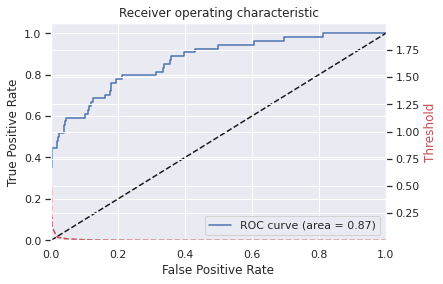

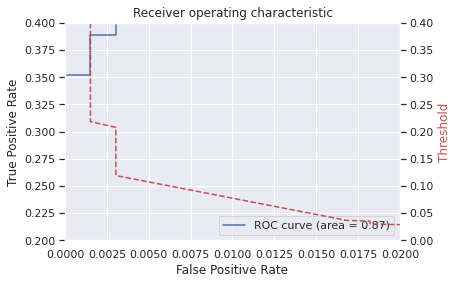

In [6]:
print ('ROC_AUC : ', roc_auc)
print ('Seuils :', seuils)
sns.set()
plt.figure()
plt.plot(faux_positifs, vrais_positifs,
         label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(faux_positifs, seuils, markeredgecolor='r',
         linestyle='dashed', color='r')
ax2.set_ylabel('Threshold', color='r')
ax2.set_ylim([seuils[-1], seuils[0]])
ax2.set_xlim([faux_positifs[0], faux_positifs[-1]])

plt.show()


sns.set()
plt.figure()
plt.plot(faux_positifs, vrais_positifs,
         label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 0.02])
plt.ylim([0.2, 0.4])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(faux_positifs, seuils, markeredgecolor='r',
         linestyle='dashed', color='r')
ax2.set_ylabel('Threshold', color='r')
ax2.set_ylim([0.0, 0.4])
ax2.set_xlim([faux_positifs[0], 0.02])
plt.show()


In [7]:
def adjusted_classes(y_scores, t):
    return [1 if y >= t else 0 for y in y_scores]

# generate new class predictions based on the adjusted_classes
# function above and view the resulting confusion matrix.

thresholds_all = [f for f in np.arange(0, 1.1, 0.1)]

f1_all = []
gain_all = []

for threshold in thresholds_all:
    print ('\nThreshold : ', threshold)
    y_pred_adj = adjusted_classes(y_score[:, 1], threshold)
    conf_matrix = pd.DataFrame(confusion_matrix(Ytest, y_pred_adj),
                               columns=['pred_neg', 'pred_pos'],
                               index=['neg', 'pos'])
    print(conf_matrix)
    f1 = f1_score(Ytest, y_pred_adj, average='weighted')
    good = conf_matrix.iloc[0, 0]
    bad = conf_matrix.iloc[1, 0]*10
    f1_all.append(f1)
    gain_all.append(good-bad)
    print ("F1 score :", f1)
    print ("Gain :", good-bad)



Threshold :  0.0
     pred_neg  pred_pos
neg         0       659
pos         0        54
F1 score : 0.010664306573213793
Gain : 0

Threshold :  0.1
     pred_neg  pred_pos
neg       656         3
pos        30        24
F1 score : 0.946467358717811
Gain : 356

Threshold :  0.2
     pred_neg  pred_pos
neg       657         2
pos        33        21
F1 score : 0.9415942429103705
Gain : 327

Threshold :  0.30000000000000004
     pred_neg  pred_pos
neg       658         1
pos        34        20
F1 score : 0.940711726703922
Gain : 318

Threshold :  0.4
     pred_neg  pred_pos
neg       658         1
pos        35        19
F1 score : 0.9385447299461755
Gain : 308

Threshold :  0.5
     pred_neg  pred_pos
neg       659         0
pos        35        19
F1 score : 0.9397788032957801
Gain : 309

Threshold :  0.6000000000000001
     pred_neg  pred_pos
neg       659         0
pos        38        16
F1 score : 0.9329848003692782
Gain : 279

Threshold :  0.7000000000000001
     pred_neg  pred_p

In [8]:
thresholds_precise = [f for f in np.arange(0.1, 0.4, 0.01)]
f1_precise = []
gain_precise = []

for threshold in thresholds_precise:
    print ('\nThreshold : ', threshold)
    y_pred_adj = adjusted_classes(y_score[:, 1], threshold)
    conf_matrix = pd.DataFrame(confusion_matrix(Ytest, y_pred_adj),
                               columns=['pred_neg', 'pred_pos'],
                               index=['neg', 'pos'])
    print(conf_matrix)
    f1 = f1_score(Ytest, y_pred_adj, average='weighted')
    good = conf_matrix.iloc[0, 0]
    bad = conf_matrix.iloc[1, 0]*10
    f1_precise.append(f1)
    gain_precise.append(good-bad)
    print ("F1 score :", f1)
    print ("Gain :", good-bad)



Threshold :  0.1
     pred_neg  pred_pos
neg       656         3
pos        30        24
F1 score : 0.946467358717811
Gain : 356

Threshold :  0.11
     pred_neg  pred_pos
neg       656         3
pos        30        24
F1 score : 0.946467358717811
Gain : 356

Threshold :  0.12
     pred_neg  pred_pos
neg       657         2
pos        31        23
F1 score : 0.9457198763361715
Gain : 347

Threshold :  0.13
     pred_neg  pred_pos
neg       657         2
pos        31        23
F1 score : 0.9457198763361715
Gain : 347

Threshold :  0.13999999999999999
     pred_neg  pred_pos
neg       657         2
pos        31        23
F1 score : 0.9457198763361715
Gain : 347

Threshold :  0.14999999999999997
     pred_neg  pred_pos
neg       657         2
pos        31        23
F1 score : 0.9457198763361715
Gain : 347

Threshold :  0.15999999999999998
     pred_neg  pred_pos
neg       657         2
pos        32        22
F1 score : 0.9436744414312346
Gain : 337

Threshold :  0.16999999999999998


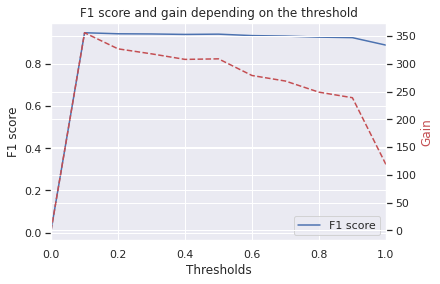

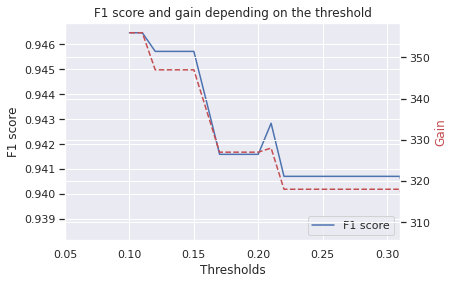

In [9]:
sns.set()
plt.figure()
plt.plot(thresholds_all, f1_all, label="F1 score")
plt.xlabel('Thresholds')
plt.ylabel('F1 score')
plt.xlim([0.0, 1.0])
plt.title('F1 score and gain depending on the threshold')
plt.legend(loc="lower right")

# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(thresholds_all, gain_all, markeredgecolor='r',
         linestyle='dashed', color='r')
ax2.set_ylabel('Gain', color='r')

plt.show()

sns.set()
plt.figure()
plt.plot(thresholds_precise, f1_precise, label="F1 score")
plt.xlabel('Thresholds')
plt.ylabel('F1 score')
plt.xlim([0.05, 0.31])
plt.title('F1 score and gain depending on the threshold')
plt.legend(loc="lower right")

# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(thresholds_precise, gain_precise, markeredgecolor='r',
         linestyle='dashed', color='r')
ax2.set_ylabel('Gain', color='r')
ax2.set_xlim([0.05, 0.31])

plt.show()


                                     feature  importance
50                          YEARS_BUILD_MODE          76
36                           YEARS_BUILD_AVG          61
31                              EXT_SOURCE_2          56
32                              EXT_SOURCE_3          51
60                        NONLIVINGAREA_MODE          40
74                        NONLIVINGAREA_MEDI          32
64                          YEARS_BUILD_MEDI          30
4                           AMT_INCOME_TOTAL          28
339           CLOSED_DAYS_CREDIT_ENDDATE_MAX          26
304                  BURO_STATUS_C_MEAN_MEAN          24
383               PREV_RATE_DOWN_PAYMENT_MIN          24
641                  INSTAL_PAYMENT_DIFF_SUM          23
59                  NONLIVINGAPARTMENTS_MODE          23
12                           DAYS_ID_PUBLISH          22
632                           INSTAL_DBD_MAX          21
240                       DAYS_EMPLOYED_PERC          21
308                   ACTIVE_DA

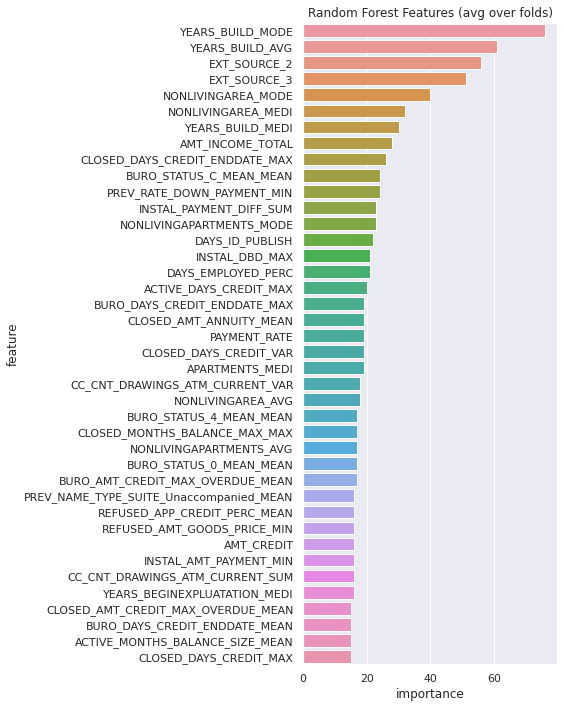

In [10]:
feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = Xtest.columns
feature_importance_df["importance"] = rf.feature_importances_
cols = feature_importance_df[[
    "feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:40].index
best_features = feature_importance_df.loc[
    feature_importance_df.feature.isin(cols)]
print (best_features.sort_values(by="importance", ascending=False))

sns.set()
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(
    by="importance", ascending=False))
plt.title('Random Forest Features (avg over folds)')
plt.tight_layout()
plt.show()


In [11]:
print ('\nThreshold : ', 0.1)
y_pred_adj = adjusted_classes(y_score[:, 1], 0.1)
print (len(y_pred_adj))
#Xtest_all['TARGET'] = y_score[:, 1]
Xtest_all['TARGET_adj'] = y_pred_adj

print (Xtest_all.columns)

filename = 'model'
outfile = open(filename,'wb')
pickle.dump(rf,outfile)
outfile.close()
print ("Enregistrement du modèle terminé")

Xtest_all.to_csv('data_model_dashboard.csv', sep='\t', index=False)
print ("Fichier CSV des données du modèle créé")
print ("Test enregistrement")
uploaded = drive.CreateFile({'title': 'data_model_dashboard.csv'})
uploaded.SetContentFile('data_model_dashboard.csv')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

best_features.to_csv('feature_importance.csv', sep='\t', index=False)
print ("Fichier de la feature importance créé")
print ("Test enregistrement")
uploaded = drive.CreateFile({'title': 'feature_importance.csv'})
uploaded.SetContentFile('feature_importance.csv')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))



Threshold :  0.1
713
Index(['index', 'SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY',
       ...
       'CC_NAME_CONTRACT_STATUS_Signed_MEAN',
       'CC_NAME_CONTRACT_STATUS_Signed_SUM',
       'CC_NAME_CONTRACT_STATUS_Signed_VAR', 'CC_NAME_CONTRACT_STATUS_nan_MIN',
       'CC_NAME_CONTRACT_STATUS_nan_MAX', 'CC_NAME_CONTRACT_STATUS_nan_MEAN',
       'CC_NAME_CONTRACT_STATUS_nan_SUM', 'CC_NAME_CONTRACT_STATUS_nan_VAR',
       'CC_COUNT', 'TARGET_adj'],
      dtype='object', length=799)
Enregistrement du modèle terminé


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Fichier CSV des données du modèle créé
Test enregistrement
Uploaded file with ID 1z8wUrKpff0Wkf0lTvfTvFjpO96jduE3l
Fichier de la feature importance créé
Test enregistrement
Uploaded file with ID 1KEjIwiVUkb45SxQg6aJIu0MSQE9_sOxS
